# Workflow d'analyse des reads RAD-seq

Kernels: bash / R

## supression des duplicatas de PCR (pair-end)

avec *clone_filter* de *Stacks* :
(remplacer les chemins des fichiers)

**tests effectués avec stacks-2.0Beta7c**

In [ ]:
# kernel: bash
clone_filter -P /media/tony/DATA2/PPOL/par_pool/ -i fastq \
    -1 PL1_Pool1_1_PoolADN1_1.fq -2 PL1_Pool1_1_PoolADN1_2.fq \
    -o /media/tony/DATA2/PPOL/par_pool/clone_filtered/ -y fastq

**resultats clone_filter sur reads1 + reads2 de PPOL:**
Pool 1: 40.91% clone reads. 
Pool 2: 42.41% clone reads. 
Pool 3: 41.53% clone reads. 
Pool 4: 41.84% clone reads. 
Pool 5: 42.13% clone reads. 
Pool 6: 41.16% clone reads.

On utilise à partir d'ici les fichiers fastq nettoyés des duplicatas de PCR.

# STACKS

La création d'une base de donnée sql est facultative. Elle peut être source de problèmes qui peuvent être contournés en créant une sortie VCF à l'étape populations.

On peut faire tourner le pipeline **denovo_map.pl** avec des paramètres spécifiques à chaque module en écrivant le flag -X "ustacks: -m 50".

La solution pas-à-pas est aussi possible, avec l'enchainement suivant : **ustacks -> cstacks -> sstacks -> tsv2bam  -> gstacks -> populations**
(gstacks n'est que dans stacks2.0)

## paramétrage du M de ustacks

Il faut tester plusieurs valeurs de M de 1 à 15 sur le Pool 1 pour paramétrer **ustacks**. Pour cela on lance le script suivant (**--max_locus_stacks** est fixé à 15). Il faut utiliser le modèle "fixed" dans **ustacks** pour correctement détecter les SNPs dans le cas d'un Pool-seq, avec une limite haute de 0.05.

In [ ]:
# kernel: bash
PROOT="./"
while read line
do
echo "*** Process parameter value -M $line ***"
ustacks -t fastq -f ./PL1_Pool1_1_PoolADN1_1.fq -i 1 \
    --model_type 'bounded' --bound_high 0.05 \
    --max_locus_stacks 15 -o ./ustacks/ -m 3 -M $line -p 32
done < ${PROOT}/M_values.txt

avec un fichier M_values.txt qui contient juste les valeurs de M : 1 2 3 4 5 10 15 (retour à la ligne entre chaque valeur), on abouti à un nombre max de SNPs détectés pour M=3.

## stacks pas-à-pas

In [ ]:
# kernel: bash
ustacks -t fastq \
    -i 11 -p 32 -m 50 -M 3 \
    --model_type 'bounded' --bound_high 0.05 --max_locus_stacks 15 \
    -o /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3 \
    -f /media/tony/DATA2/PPOL_DATA2/PPOL_fastq_par_pool/clone_filtered/reads1/PL1_Pool1_1_PoolADN1_1_1.fq
ustacks -t fastq \
    -i 12 -p 32 -m 50 -M 3 \
    --model_type 'bounded' --bound_high 0.05 --max_locus_stacks 15 \
    -o /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3 \
    -f /media/tony/DATA2/PPOL_DATA2/PPOL_fastq_par_pool/clone_filtered/reads1/PL1_Pool1_2_PoolADN2_1_1.fq
ustacks -t fastq \
    -i 13 -p 32 -m 50 -M 3 \
    --model_type 'bounded' --bound_high 0.05 --max_locus_stacks 15 \
    -o /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3 \
    -f /media/tony/DATA2/PPOL_DATA2/PPOL_fastq_par_pool/clone_filtered/reads1/PL1_Pool1_3_PoolADN3_1_1.fq
ustacks -t fastq \
    -i 14 -p 32 -m 50 -M 3 \
    --model_type 'bounded' --bound_high 0.05 --max_locus_stacks 15 \
    -o /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3 \
    -f /media/tony/DATA2/PPOL_DATA2/PPOL_fastq_par_pool/clone_filtered/reads1/PL1_Pool1_4_PoolADN4_1_1.fq
ustacks -t fastq \
    -i 15 -p 32 -m 50 -M 3 \
    --model_type 'bounded' --bound_high 0.05 --max_locus_stacks 15 \
    -o /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3 \
    -f /media/tony/DATA2/PPOL_DATA2/PPOL_fastq_par_pool/clone_filtered/reads1/PL1_Pool1_5_PoolADN5_1_1.fq
ustacks -t fastq \
    -i 16 -p 32 -m 50 -M 3 \
    --model_type 'bounded' --bound_high 0.05 --max_locus_stacks 15 \
    -o /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3 \
    -f /media/tony/DATA2/PPOL_DATA2/PPOL_fastq_par_pool/clone_filtered/reads1/PL1_Pool1_6_PoolADN6_1_1.fq

In [ ]:
# kernel: bash
cstacks -n 3 -p 32 -b 8 \
    -P /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3/ \
    -M /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/population_map_local.txt

*Ustacks* crée les fichiers PL1_Pool1_1_PoolADN1_1_1.alleles.tsv, + models.tsv + snps.tsv + tags.tsv pour chaque pool ;
*Cstacks* crée les fichiers batch_4.catalog alleles + snps + tags ;
*Sstacks* crée les fichiers PL1_Pool1_1_PoolADN1_1_1.matches.tsv pour chaque pool.

In [ ]:
# kernel: bash
sstacks -b 8 -p 32 -P /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3 \
    -M /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/population_map_local.txt

apres le denovomap avec un modèle "fixed SNP" adapté au Pool-seq, il faut faire tourner populations en local, avec STACKS2.0, qui comporte le nouvel outil *gstacks*;
d'abord on convertit les output du denovomap en bam avec *tsv2bam*;
puis *gstacks* cherche les SNPs dans les .bam;
enfin *populations* établit les VCF avec le nombre de reads par allèle, qui, rapporté au nombre de reads du locus, permet de calculer la fréquence allélique de chaque allèle.

In [ ]:
# kernel: bash
cd /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3/
tsv2bam -P ./ -M ./population_map_local.txt -b 8 -t 32

**populations** le paramètre -p 6 signifie que les clusters doivent être communs aux 6 pools (pas de N).

In [ ]:
# kernel: bash
gstacks -P ./ --model snp -t 32 -b 8
populations -P ./ -O ./populations_p6/ \
    -M ./population_map_local.txt -p 6 \
    --vcf --vcf_haplotypes --min_maf 0

## pipeline denovo_map

**PPOL**

In [3]:
# kernel: bash
cd ~/sync/genetique_poissons/RAD-seq_PPOL/
denovo_map.pl -S -b 8 -T 32 -m 50 -M 3 -n 3 \
    --samples ./PPOL_DATA2/PPOL_fastq_clone_filtered/reads1/ \
    --popmap ./PPOL_DATA2/PPOL_fastq_clone_filtered/reads1/population_map_PPOL.txt \
    -o /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3/ \
    -X "ustacks: --max_locus_stacks 15 --model_type 'bounded' --bound_high 0.05" \
    -X "/usr/bin/bin/tsv2bam: -b 8 -t 32 -P ./PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3 -M ./PPOL_DATA2/PPOL_fastq_clone_filtered/reads1/population_map_PPOL.txt" \
    -X "populations: -p 6 --vcf --vcf_haplotypes --min_maf 0 \
        -O /media/tony/DATA2/PPOL/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3/populations_p6"

You must specify a batch ID and it must be an integer (e.g. 1, 2, 3).
denovo_map.pl 2.0Beta1
denovo_map.pl --samples dir --popmap path -o dir (assembly options) -b batch_id (database options) [-X prog:"opts" ...]
denovo_map.pl -s path [-s path ...] -o dir (assembly options) -b batch_id (database options) [-X prog:"opts" ...]
denovo_map.pl -p path -r path -o path -A type (assembly options) -b batch_id (database options) [-X prog:"opts" ...]

  Input files:
    --samples: path to the directory containing the samples reads files.
    --popmap: path to a population map file (format is "<name> TAB <pop>", one sample per line).
  or
    s: path to a file containing the reads of one sample.
  or
    p: path to a file containing the reads of one parent, in a mapping cross.
    r: path to a file containing the reads of one progeny, in a mapping cross.

  General options:
    o: path to an output directory.
    b: a numeric database ID for this run (e.g. 1).
    A: for a mapping cross, specify t

: 1

**MSUR**

In [ ]:
# kernel: bash
cd ~/sync/genetique_poissons/RAD-seq_MSUR/
denovo_map.pl -T 32 -m 50 -M 3 -n 3 \
    --samples ./MSUR_DATA2/MSUR_fastq_clone_filtered/reads1/ \
    --popmap ./MSUR_DATA2/MSUR_fastq_clone_filtered/reads1/population_map_MSUR.txt \
    -o /media/tony/DATA2/MSUR_DATA2/bio_info_MSUR/stacks/denovo_map_filtered_bounded/ustacks_m50_M3/ \
    -X "ustacks: --max_locus_stacks 15 --model_type 'bounded' --bound_high 0.05" \
    -X "populations: -p 7 --vcf --vcf_haplotypes --min_maf 0 \
        -O /media/tony/DATA2/MSUR_DATA2/bio_info_MSUR/stacks/denovo_map_filtered_bounded/ustacks_m50_M3/populations_p7"

# DiscoSnp-Rad

Tous les paramètres de DiscoSnp-Rad sont automatiques, sauf :
-P polymorphisme maximal autorisé par bulle: -P 3, 15
-c minimum coverage per read set (auto: défini par kissnp2): -c auto, 50
La valeur automatique de c est plutôt vers 200-300.
    Essais sur plusieurs configurations: -P 3 -c auto
                                        -P 15 -c auto
                                        -P 3 -c 50
                                        -P 15 -c 50

**PPOL**

In [ ]:
# kernel: bash
cd ~/DiscoSnp/
sudo ./run_discoSnpRad.sh -r fof_reads1_PPOL.txt -P 3 -p "PPOL_disco_P3_c-auto" -T -c auto -u 32 -S ./rconnector
# sudo ./run_discoSnpRad.sh -r fof_reads1.txt -P 15 -p "PPOL_disco_P15_c-auto" -T -c auto -u 32 -S ./rconnector
# sudo ./run_discoSnpRad.sh -r fof_reads1.txt -P 3 -p "PPOL_disco_P3_c-50" -T -c 50 -u 32 -S ./rconnector
# sudo ./run_discoSnpRad.sh -r fof_reads1.txt -P 15 -p "PPOL_disco_P15_c-auto" -T -c 50 -u 32 -S ./rconnector

**MSUR**

In [ ]:
# kernel: bash
cd ~/DiscoSnp/
sudo ./run_discoSnpRad.sh -r fof_reads1_MSUR.txt -P 3 -p "MSUR_disco_P3_c-auto" -T -c auto -u 32 -S ./rconnector
# sudo ./run_discoSnpRad.sh -r fof_reads1.txt -P 15 -p "PPOL_disco_P15_c-auto" -T -c auto -u 32 -S ./rconnector
# sudo ./run_discoSnpRad.sh -r fof_reads1.txt -P 3 -p "PPOL_disco_P3_c-50" -T -c 50 -u 32 -S ./rconnector
# sudo ./run_discoSnpRad.sh -r fof_reads1.txt -P 15 -p "PPOL_disco_P15_c-auto" -T -c 50 -u 32 -S ./rconnector

## **Visualisation des profondeurs de clusters **

d'abord ouvrir les sorties vcf de **population** pour effacer les headers, puis les enregistrer en csv

**PPOL**

In [ ]:
# kernel: R
library(ggplot2)
library(gridExtra)
library(adegenet)
library(pegas)
library(poppr)
library(vegan)
library(dplyr)
library(stringr)

AD_STACKS_m3 <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/stacks/sorties_denovomap/PPOL_denovo_m3_M3_n3_p6.csv" %>% read.csv() %>% as_tibble()
AD_STACKS_m50 <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/stacks/sorties_denovomap/PPOL_denovo_m50_M3_n3_p6.csv" %>% read.csv() %>% as_tibble()
AD_STACKS_m200 <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/stacks/sorties_denovomap/PPOL_denovo_m200_M3_n3_p6.csv" %>% read.csv() %>% as_tibble()
AD_Disco_P3_cauto_SNPs <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/sorties_discoSnpRad/PPOL_disco_P3_c-auto_k_31.csv" %>% read.csv() %>% as_tibble() %>% filter(str_detect(ID, "SNP"))
AD_Disco_P3_c50_SNPs <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/sorties_discoSnpRad/PPOL_disco_P3_c50_k_31.csv" %>% read.csv() %>% as_tibble() %>% filter(str_detect(ID, "SNP"))
AD_Disco_P15_cauto_SNPs <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/sorties_discoSnpRad/PPOL_disco_P15_c-auto_k_31.csv" %>% read.csv() %>% as_tibble() %>% filter(str_detect(ID, "SNP"))
AD_Disco_P15_c50_SNPs <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/sorties_discoSnpRad/PPOL_disco_P15_c50_k_31.csv" %>% read.csv() %>% as_tibble() %>% filter(str_detect(ID, "SNP"))

length(AD_STACKS_m3$ID) # [1] 38828 SNPs
length(AD_STACKS_m50$ID) # [1] 7204 SNPs
length(AD_STACKS_m200$ID) # [1] 4354 SNPs
length(AD_Disco_P3_cauto_SNPs$ID) # [1] 21134 SNPs (INDELs supprimés)
length(AD_Disco_P3_c50_SNPs$ID) # [1] 25034 SNPs
length(AD_Disco_P15_cauto_SNPs$ID) # [1] 24141 SNPs
length(AD_Disco_P15_c50_SNPs$ID) # [1] 28215 SNPs


a <- ggplot(AD_STACKS_m3) + geom_bar(aes(G1, group = cut_width(G1, 100))) + theme_classic() + 
  scale_x_continuous(limits = c(0, 1500)) + expand_limits(y=400) +
  labs(x="cluster coverage", y="count", title="Stacks denovo map (Pool 1) m3 M3 n3, 38828 SNPs") + 
  theme(plot.title = element_text(size=8))
b <- ggplot(AD_STACKS_m50) + geom_bar(aes(G1, group = cut_width(G1, 50))) + theme_classic() + 
  scale_x_continuous(limits = c(0, 1500)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="Stacks denovo map (Pool 1) m50 M3 n3, 7204 SNPs")+ 
  theme(plot.title = element_text(size=8))
c <- ggplot(AD_STACKS_m200) + geom_bar(aes(G1, group = cut_width(G1, 50))) + theme_classic() + 
  scale_x_continuous(limits = c(0, 1500)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="Stacks denovo map (Pool 1) m200 M3 n3, 4354 SNPs")+ 
  theme(plot.title = element_text(size=8))
d <- ggplot(AD_Disco_P3_cauto_SNPs) + geom_bar(aes(G1, group = cut_width(G1, 100))) + theme_classic() +
  scale_x_continuous(limits = c(0, 2000)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="DiscoSnpRAD (Pool 1, SNPs) -P 3 -c auto, 21134 SNPs")+ 
  theme(plot.title = element_text(size=8))
e <- ggplot(AD_Disco_P3_c50_SNPs) + geom_bar(aes(G1, group = cut_width(G1, 100))) + theme_classic() +
  scale_x_continuous(limits = c(0, 2000)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="DiscoSnpRAD (Pool 1, SNPs) -P 3 -c 50, 25034 SNPs")+ 
  theme(plot.title = element_text(size=8))
f <- ggplot(AD_Disco_P15_cauto_SNPs) + geom_bar(aes(G1, group = cut_width(G1, 100))) + theme_classic() +
  scale_x_continuous(limits = c(0, 2000)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="DiscoSnpRAD (Pool 1, SNPs) -P 15 -c auto, 24141 SNPs")+ 
  theme(plot.title = element_text(size=8))
g <- ggplot(AD_Disco_P15_c50_SNPs) + geom_bar(aes(G1, group = cut_width(G1, 100))) + theme_classic() +
  scale_x_continuous(limits = c(0, 2000)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="DiscoSnpRAD (Pool 1, SNPs) -P 15 -c 50, 28215 SNPs")+ 
  theme(plot.title = element_text(size=8))

grid.arrange(d,a, e, b, f, c, g, ncol=2, nrow=4)




**MSUR**

In [ ]:
# kernel: R
library(ggplot2)
library(gridExtra)
library(adegenet)
library(pegas)
library(poppr)
library(vegan)
library(dplyr)
library(stringr)


AD_STACKS_m50 <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/stacks/sorties_denovomap/PPOL_denovo_m50_M3_n3_p6.csv" %>% read.csv() %>% as_tibble()
AD_Disco_P3_cauto_SNPs <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/sorties_discoSnpRad/PPOL_disco_P3_c-auto_k_31.csv" %>% read.csv() %>% as_tibble() %>% filter(str_detect(ID, "SNP"))
length(AD_STACKS_m50$ID) # [1] 7204 SNPs
length(AD_Disco_P3_cauto_SNPs$ID) # [1] 21134 SNPs (INDELs supprimés)

a <- ggplot(AD_STACKS_m3) + geom_bar(aes(G1, group = cut_width(G1, 100))) + theme_classic() + 
  scale_x_continuous(limits = c(0, 1500)) + expand_limits(y=400) +
  labs(x="cluster coverage", y="count", title="Stacks denovo map (Pool 1) m3 M3 n3, 38828 SNPs") + 
  theme(plot.title = element_text(size=8))
b <- ggplot(AD_STACKS_m50) + geom_bar(aes(G1, group = cut_width(G1, 50))) + theme_classic() + 
  scale_x_continuous(limits = c(0, 1500)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="Stacks denovo map (Pool 1) m50 M3 n3, 7204 SNPs")+ 
  theme(plot.title = element_text(size=8))
c <- ggplot(AD_STACKS_m200) + geom_bar(aes(G1, group = cut_width(G1, 50))) + theme_classic() + 
  scale_x_continuous(limits = c(0, 1500)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="Stacks denovo map (Pool 1) m200 M3 n3, 4354 SNPs")+ 
  theme(plot.title = element_text(size=8))
d <- ggplot(AD_Disco_P3_cauto_SNPs) + geom_bar(aes(G1, group = cut_width(G1, 100))) + theme_classic() +
  scale_x_continuous(limits = c(0, 2000)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="DiscoSnpRAD (Pool 1, SNPs) -P 3 -c auto, 21134 SNPs")+ 
  theme(plot.title = element_text(size=8))
e <- ggplot(AD_Disco_P3_c50_SNPs) + geom_bar(aes(G1, group = cut_width(G1, 100))) + theme_classic() +
  scale_x_continuous(limits = c(0, 2000)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="DiscoSnpRAD (Pool 1, SNPs) -P 3 -c 50, 25034 SNPs")+ 
  theme(plot.title = element_text(size=8))
f <- ggplot(AD_Disco_P15_cauto_SNPs) + geom_bar(aes(G1, group = cut_width(G1, 100))) + theme_classic() +
  scale_x_continuous(limits = c(0, 2000)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="DiscoSnpRAD (Pool 1, SNPs) -P 15 -c auto, 24141 SNPs")+ 
  theme(plot.title = element_text(size=8))
g <- ggplot(AD_Disco_P15_c50_SNPs) + geom_bar(aes(G1, group = cut_width(G1, 100))) + theme_classic() +
  scale_x_continuous(limits = c(0, 2000)) + scale_y_continuous(limits = c(0, 75)) +
  labs(x="cluster coverage", y="count", title="DiscoSnpRAD (Pool 1, SNPs) -P 15 -c 50, 28215 SNPs")+ 
  theme(plot.title = element_text(size=8))

grid.arrange(d,a, e, b, f, c, g, ncol=2, nrow=4)

## Filtres qualité

In [1]:
library(dplyr)
library(tidyr)
library(stringr)

AD_Disco_PPOL_P3_cauto_SNPs <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/sorties_discoSnpRad/PPOL_disco_P3_c-auto_k_31.csv" %>% read.csv() %>% as_tibble() %>% filter(str_detect(ID, "SNP"))
AD_Disco_MSUR_P3_cauto_SNPs <- "~/sync/genetique_poissons/RAD-seq_MSUR/bio-info/discoSNPRAD/raw_MSUR_disco_P3_c-auto_k_31_c_auto_D_100_P_3_b_1_coherent_sorted_with_clusters.csv"  %>% read.csv() %>% as_tibble() %>% filter(str_detect(ID, "SNP"))

c("Ecosse-Mer du Nord","Mer celtique","Mer d'Irlande_Pays de Galles","Manche Ouest","Gascogne France","Gascogne Espagne")-> PPOL_pool_names
c("Ecosse_mer_du_Nord","Sud Irlande","Manche ouest","Gascogne France","Gascogne Espagne","Portugal")-> MSUR_pool_names

##############
### FILTRATION
##############
# PPOL
# au moins un score phred > 30
AD_Disco_PPOL_P3_cauto_SNPs_phr30 <- AD_Disco_PPOL_P3_cauto_SNPs %>% filter(.,max(ph1,ph2,ph3)>30,max(ph1.1,ph2.1,ph3.1)>30,max(ph1.2,ph2.2,ph3.2)>30,max(ph1.3,ph2.3,ph3.3)>30,max(ph1.4,ph2.4,ph3.4)>30,max(ph1.5,ph2.5,ph3.5)>30)
# 50x min dans chaque pool (juste un contrôle, car déjà paramétrisé dans stacks et Disco)
AD_Disco_PPOL_P3_cauto_SNPs_50x <- filter(AD_Disco_PPOL_P3_cauto_SNPs_phr30,G1>=50,G2>=50,G3>=50,G4>=50,G5>=50,G6>=50)
# les loci sont polymorphiques dans tous les pools
AD_Disco_PPOL_P3_cauto_SNPs_50x_polyALL <- filter(AD_Disco_PPOL_P3_cauto_SNPs_50x,G1_1>0,G1_2>0,G2_1>0,G2_2>0,G3_1>0,G3_2>0,G4_1>0,G4_2>0,G5_1>0,G5_2>0,G6_1>0,G6_2>0)
# on calcule les FA
AD_Disco_PPOL_P3_cauto_SNPs_50x_polyALL %>% transmute(.,X.CHROM=X.CHROM,G1_1p=G1_1/G1,G1_2p=G1_2/G1,G2_1p=G2_1/G2,G2_2p=G2_2/G2,G3_1p=G3_1/G3,
                                                      G3_2p=G3_2/G3,G4_1p=G4_1/G4,G4_2p=G4_2/G4,G5_1p=G5_1/G5,G5_2p=G5_2/G5,
                                                      G6_1p=G6_1/G6,G6_2p=G6_2/G6) -> PPOL_FA
# MSUR
AD_Disco_MSUR_P3_cauto_SNPs_phr30 <- AD_Disco_MSUR_P3_cauto_SNPs %>% filter(.,max(ph1,ph2,ph3)>30,max(ph1.1,ph2.1,ph3.1)>30,max(ph1.2,ph2.2,ph3.2)>30,max(ph1.3,ph2.3,ph3.3)>30,max(ph1.4,ph2.4,ph3.4)>30,max(ph1.5,ph2.5,ph3.5)>30)
AD_Disco_MSUR_P3_cauto_SNPs <- select(AD_Disco_MSUR_P3_cauto_SNPs_phr30,X.CHROM, POS, G1,G1_1,G1_2,G2,G2_1,G2_2,G3,G3_1,G3_2,G4,G4_1,G4_2,G5,G5_1,G5_2,G6,G6_1,G6_2)
AD_Disco_MSUR_P3_cauto_SNPs_50x <- filter(AD_Disco_MSUR_P3_cauto_SNPs,G1>=50,G2>=50,G3>=50,G4>=50,G5>=50,G6>=50)
AD_Disco_MSUR_P3_cauto_SNPs_50x_polyALL <- filter(AD_Disco_MSUR_P3_cauto_SNPs_50x,G1_1>0,G1_2>0,G2_1>0,G2_2>0,G3_1>0,G3_2>0,G4_1>0,G4_2>0,G5_1>0,G5_2>0,G6_1>0,G6_2>0)
AD_Disco_MSUR_P3_cauto_SNPs_50x_polyALL %>% transmute(.,X.CHROM=X.CHROM,G1_1p=G1_1/G1,G1_2p=G1_2/G1,G2_1p=G2_1/G2,G2_2p=G2_2/G2,G3_1p=G3_1/G3,
                                                      G3_2p=G3_2/G3,G4_1p=G4_1/G4,G4_2p=G4_2/G4,G5_1p=G5_1/G5,G5_2p=G5_2/G5,
                                                      G6_1p=G6_1/G6,G6_2p=G6_2/G6) -> MSUR_FA

'PPOL: nombre total de SNPs'
tally(PPOL_FA)
'MSUR: nombre total de SNPs'
tally(MSUR_FA)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



[1] "PPOL: nombre total de SNPs"

n
21060


[1] "MSUR: nombre total de SNPs"

n
58244


# Diversités nucléotidiques pi

Seul stacks fournit un calcul de pi dans **populations.sumstats_summary.tsv** calculé par *populations*.
Donc il faut d'abord récupérer les POS des SNPs après filtrage, puis les mettre dans une whitelist qui sera ensuite utilisée par *populations*.

In [7]:
# kernel: R
library(dplyr)
library(stringr)

AD_STACKS_PPOL <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/stacks/sorties_denovomap/PPOL_denovo_m50_M3_n3_p6.csv" %>% read.csv() %>% as_tibble()
AD_STACKS_MSUR <- "~/sync/genetique_poissons/RAD-seq_MSUR/bio-info/stacks/MSUR_denovo_m50_M3_p7.csv" %>% read.csv() %>% as_tibble()


##############
### FILTRATION
##############
# PPOL
# 50x min dans chaque pool (juste un contrôle, car déjà paramétrisé dans stacks et Disco)
AD_STACKS_PPOL_50x <- filter(AD_STACKS_PPOL,POS,G1>=50,G2>=50,G3>=50,G4>=50,G5>=50,G6>=50)
# les loci sont polymorphiques dans tous les pools
AD_STACKS_PPOL_50x_polyALL <- filter(AD_STACKS_PPOL_50x,POS,G1_1>0,G1_2>0,G2_1>0,G2_2>0,G3_1>0,G3_2>0,G4_1>0,G4_2>0,G5_1>0,G5_2>0,G6_1>0,G6_2>0) # 7140 SNPs
AD_STACKS_PPOL_50x_polyALL %>% transmute(.,POS=POS,ID=ID,G1_1p=G1_1/G1,G1_2p=G1_2/G1,G2_1p=G2_1/G2,G2_2p=G2_2/G2,G3_1p=G3_1/G3,
                                         G3_2p=G3_2/G3,G4_1p=G4_1/G4,G4_2p=G4_2/G4,G5_1p=G5_1/G5,G5_2p=G5_2/G5,
                                         G6_1p=G6_1/G6,G6_2p=G6_2/G6) -> PPOL_STACKS_FA
# min MAF = 0.1, max MAF = 0.9
PPOL_STACKS_FA <- filter(PPOL_STACKS_FA,G1_1p>=0.1,G1_2p>=0.1,G2_1p>=0.1,G1_2p>=0.1,G3_1p>=0.1,G3_2p>=0.1,G4_1p>=0.1,G4_2p>=0.1,G5_1p>=0.1,G5_2p>=0.1,G6_1p>=0.1,G6_2p>=0.1)
PPOL_STACKS_FA <- filter(PPOL_STACKS_FA,G1_1p<=0.9,G1_2p<=0.9,G2_1p<=0.9,G1_2p<=0.9,G3_1p<=0.9,G3_2p<=0.9,G4_1p<=0.9,G4_2p<=0.9,G5_1p<=0.9,G5_2p<=0.9,G6_1p<=0.9,G6_2p<=0.9)
tally(PPOL_STACKS_FA) # 7056 SNPs

# MSUR
AD_STACKS_MSUR_50x <- filter(AD_STACKS_MSUR,POS,G1>=50,G2>=50,G3>=50,G4>=50,G5>=50,G6>=50,G7>=50)
AD_STACKS_MSUR_50x_polyALL <- filter(AD_STACKS_MSUR_50x,POS,G1_1>0,G1_2>0,G2_1>0,G2_2>0,G3_1>0,G3_2>0,G4_1>0,G4_2>0,G5_1>0,G5_2>0,G6_1>0,G6_2>0)
AD_STACKS_MSUR_50x_polyALL %>% transmute(.,POS=POS,POS,G1_1p=G1_1/G1,G1_2p=G1_2/G1,G2_1p=G2_1/G2,G2_2p=G2_2/G2,G3_1p=G3_1/G3,
                                         G3_2p=G3_2/G3,G4_1p=G4_1/G4,G4_2p=G4_2/G4,G5_1p=G5_1/G5,G5_2p=G5_2/G5,
                                         G6_1p=G6_1/G6,G6_2p=G6_2/G6,G7_1p=G7_1/G7,G7_2p=G7_2/G7) -> MSUR_ATLMED_STACKS_FA
AD_STACKS_MSUR_50x_polyALL %>% transmute(.,POS=POS,G1_1p=G1_1/G1,G1_2p=G1_2/G1,G2_1p=G2_1/G2,G2_2p=G2_2/G2,G3_1p=G3_1/G3,
                                         G3_2p=G3_2/G3,G4_1p=G4_1/G4,G4_2p=G4_2/G4,G5_1p=G5_1/G5,G5_2p=G5_2/G5,
                                         G6_1p=G6_1/G6,G6_2p=G6_2/G6) -> MSUR_ATL_STACKS_FA
# min MAF = 0.1, max MAF = 0.9
MSUR_ATLMED_STACKS_FA <- filter(MSUR_ATLMED_STACKS_FA,G1_1p>=0.1,G1_2p>=0.1,G2_1p>=0.1,G1_2p>=0.1,G3_1p>=0.1,G3_2p>=0.1,G4_1p>=0.1,G4_2p>=0.1,G5_1p>=0.1,G5_2p>=0.1,G6_1p>=0.1,G6_2p>=0.1)
MSUR_ATLMED_STACKS_FA <- filter(MSUR_ATLMED_STACKS_FA,G1_1p<=0.9,G1_2p<=0.9,G2_1p<=0.9,G1_2p<=0.9,G3_1p<=0.9,G3_2p<=0.9,G4_1p<=0.9,G4_2p<=0.9,G5_1p<=0.9,G5_2p<=0.9,G6_1p<=0.9,G6_2p<=0.9)
tally(MSUR_ATLMED_STACKS_FA) # 9768 SNPs
# min MAF = 0.1, max MAF = 0.9
MSUR_ATL_STACKS_FA <- filter(MSUR_ATL_STACKS_FA,G1_1p>=0.1,G1_2p>=0.1,G2_1p>=0.1,G1_2p>=0.1,G3_1p>=0.1,G3_2p>=0.1,G4_1p>=0.1,G4_2p>=0.1,G5_1p>=0.1,G5_2p>=0.1,G6_1p>=0.1,G6_2p>=0.1)
MSUR_ATL_STACKS_FA <- filter(MSUR_ATL_STACKS_FA,G1_1p<=0.9,G1_2p<=0.9,G2_1p<=0.9,G1_2p<=0.9,G3_1p<=0.9,G3_2p<=0.9,G4_1p<=0.9,G4_2p<=0.9,G5_1p<=0.9,G5_2p<=0.9,G6_1p<=0.9,G6_2p<=0.9)
tally(MSUR_ATL_STACKS_FA) # 9768 SNPs


###################
# WHITELISTS Stacks
###################

AD_STACKS_PPOL_50x_polyALL %>% select(POS) %>% 
  write.table(.,"~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/stacks/sorties_denovomap/Whitelist_AD_STACKS_PPOL_50x_polyALL.txt",sep=" ",col.names=F,row.names=F)
AD_STACKS_MSUR_50x_polyALL %>% select(POS) %>% 
  write.table(.,"~/sync/genetique_poissons/RAD-seq_MSUR/bio-info/stacks/Whitelist_AD_STACKS_MSUR_50x_polyALL.txt",sep=" ",col.names=F,row.names=F)




# SNPs fixés avec DiscoSNP
# MSUR_ATLMED_FA %>% filter(.,G7_1p==0) # 1,755 
# MSUR_ATLMED_FA %>% filter(.,G7_1p==1) # 1,432
## il y a 3187 SNPs fixés dans le G7 MSUR (MED)

# SNPs fixés avec STACKS
MSUR_ATLMED_STACKS_FA %>% filter(.,G7_1p==0) %>% tally() # 139
MSUR_ATLMED_STACKS_FA %>% filter(.,G7_2p==0) %>% tally() # 3431
# il y a 3570 SNPs ATL qui sont fixés dans MED (sur 9768=36.5%)

n
7056


n
9768


n
9768


n
139


n
3431


In [2]:
# kernel: bash
# avec whitelist
cd ~/sync/genetique_poissons/RAD-seq_PPOL/
denovo_map.pl -S -b 8 -T 32 -m 50 -M 3 -n 3 \
    --samples ./PPOL_DATA2/PPOL_fastq_clone_filtered/reads1/ \
    --popmap ./PPOL_DATA2/PPOL_fastq_clone_filtered/reads1/population_map_PPOL.txt \
    -o /media/tony/DATA2/PPOL_DATA2/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3/ \
    -X "ustacks: --max_locus_stacks 15 --model_type 'bounded' --bound_high 0.05" \
    -X "populations: -p 6 --vcf --vcf_haplotypes --min_maf 0 \
        -W ~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/stacks/sorties_denovomap/Whitelist_AD_STACKS_PPOL_50x_polyALL.txt \
        -O /media/tony/DATA2/PPOL/bio_info_PPOL/stacks/denovo_map_filtered_bounded/ustacks_m50_M3/populations_p6"

populations parameters selected:
  Fst kernel smoothing: off
  Bootstrap resampling: off
  Percent samples limit per population: 0
  Locus Population limit: 6
  Minimum stack depth: 0
  Log liklihood filtering: off; threshold: 0
  Minor allele frequency cutoff: 0.1
  Maximum observed heterozygosity cutoff: 1
  Applying Fst correction: none.

Error: Failed to create directory './populations_p6/calcul_pi'.
Aborted.


: 13

# Scan génomique  - recherche d'outliers : BayeScan
## préparation du fichier bayescan

In [ ]:
# kernel: R
# à partir des objets R créés précédemment

## PPOL
#######
pop1=pop2=pop3=pop4=pop5=pop6=NULL
tally(PPOL)->loci_id_PPOL # 21060
pop1$V1=pop2$V1=pop3$V1=pop4$V1=pop5$V1=pop6$V1 <- as.vector(c(1:loci_id_PPOL$n))
pop1$V3=pop2$V3=pop3$V3=pop4$V3=pop5$V3=pop6$V3 <- as.vector(rep(2, each=loci_id_PPOL$n))

pop1$V2 <- as.vector(PPOL$G1)
pop1$V4 <- as.vector(PPOL$G1_1)
pop1$V5 <- as.vector(PPOL$G1_2)
pop1 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/fichiers_bayescan/pop1.csv", row.names = F)

pop2$V2 <- as.vector(PPOL$G2)
pop2$V4 <- as.vector(PPOL$G2_1)
    pop2$V5 <- as.vector(PPOL$G2_2)
pop2 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/fichiers_bayescan/pop2.csv", row.names = F)

pop3$V2 <- as.vector(PPOL$G3)
pop3$V4 <- as.vector(PPOL$G3_1)
pop3$V5 <- as.vector(PPOL$G3_2)
pop3 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/fichiers_bayescan/pop3.csv", row.names = F)

pop4$V2 <- as.vector(PPOL$G4)
pop4$V4 <- as.vector(PPOL$G4_1)
pop4$V5 <- as.vector(PPOL$G4_2)
pop4 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/fichiers_bayescan/pop4.csv", row.names = F)

pop5$V2 <- as.vector(PPOL$G5)
pop5$V4 <- as.vector(PPOL$G5_1)
pop5$V5 <- as.vector(PPOL$G5_2)
pop5 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/fichiers_bayescan/pop5.csv", row.names = F)

pop6$V2 <- as.vector(PPOL$G6)
pop6$V4 <- as.vector(PPOL$G6_1)
pop6$V5 <- as.vector(PPOL$G6_2)
pop6 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/fichiers_bayescan/pop6.csv", row.names = F)

In [ ]:
# kernel: R
## MSUR
#######
tally(MSUR_P6)->loci_id_MSUR # 58244
pop1$V1=pop2$V1=pop3$V1=pop4$V1=pop5$V1=pop6$V1 <- as.vector(c(1:loci_id_MSUR$n))
pop1$V3=pop2$V3=pop3$V3=pop4$V3=pop5$V3=pop6$V3 <- as.vector(rep(2, each=loci_id_MSUR$n))

pop1$V2 <- as.vector(MSUR_P6$G1)
pop1$V4 <- as.vector(MSUR_P6$G1_1)
pop1$V5 <- as.vector(MSUR_P6$G1_2)
pop1 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_MSUR/bio-info/discoSNPRAD/fichiers_bayescan/pop1.csv", row.names = F)

pop2$V2 <- as.vector(MSUR_P6$G2)
pop2$V4 <- as.vector(MSUR_P6$G2_1)
pop2$V5 <- as.vector(MSUR_P6$G2_2)
pop2 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_MSUR/bio-info/discoSNPRAD/fichiers_bayescan/pop2.csv", row.names = F)

pop3$V2 <- as.vector(MSUR_P6$G3)
pop3$V4 <- as.vector(MSUR_P6$G3_1)
pop3$V5 <- as.vector(MSUR_P6$G3_2)
pop3 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_MSUR/bio-info/discoSNPRAD/fichiers_bayescan/pop3.csv", row.names = F)

pop4$V2 <- as.vector(MSUR_P6$G4)
pop4$V4 <- as.vector(MSUR_P6$G4_1)
pop4$V5 <- as.vector(MSUR_P6$G4_2)
pop4 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_MSUR/bio-info/discoSNPRAD/fichiers_bayescan/pop4.csv", row.names = F)

pop5$V2 <- as.vector(MSUR_P6$G5)
pop5$V4 <- as.vector(MSUR_P6$G5_1)
pop5$V5 <- as.vector(MSUR_P6$G5_2)
pop5 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_MSUR/bio-info/discoSNPRAD/fichiers_bayescan/pop5.csv", row.names = F)

pop6$V2 <- as.vector(MSUR_P6$G6)
pop6$V4 <- as.vector(MSUR_P6$G6_1)
pop6$V5 <- as.vector(MSUR_P6$G6_2)
pop6 %>% as_data_frame() %>% select(.,V1,V2,V3,V4,V5) %>% 
  write.csv(.,"~/sync/genetique_poissons/RAD-seq_MSUR/bio-info/discoSNPRAD/fichiers_bayescan/pop6.csv", row.names = F)

A partir des fichiers popX.csv, fabriquer le fichier .txt de bayescan (format csv sep=tab, avec l'extension .txt). Attention à bien respecter le format standard, sans ligne vide importune.
## Bayescan
pour PPOL, puis MSUR

In [ ]:
# kernel: bash
cd ~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/fichiers_bayescan/
# mettre l'executable de bayescan linux dans le répertoire, ou le sourcer dans le PATH
./BayeScan2.1_linux64bits ./PPOL_DiscoSnpRad_P3_cauto_bayescan.txt  -o bayescanLongRunOD10_PPOL_DiscoSnpRad_P3_cauto -n 5000 -thin 10 -pilot 5000 -burn 50000 -pr_odds 10

In [ ]:
# kernel: bash
cd ~/sync/genetique_poissons/RAD-seq_MSUR/bio-info/discoSNPRAD/fichiers_bayescan/
# mettre l'executable de bayescan linux dans le répertoire, ou le sourcer dans le PATH
./BayeScan2.1_linux64bits ./MSUR_disco_P3_cauto_bayescan.txt  -o bayescanLongRunOD10_MSUR_DiscoSnpRad_P3_cauto -n 5000 -thin 10 -pilot 5000 -burn 50000 -pr_odds 10

# Analyse de la structure populationnelle


Il faut avoir au préalable retiré les outliers Bayescan pour construire 2 jeux par espèce:
- un jeu d'outliers
- un jeu de marqueurs neutres

In [2]:
# kernel: R
library(dplyr)
library(tidyr)
library(stringr)

################################
# séparation outliers // neutres
################################
# FA
PPOL_bayescan <- "~/sync/genetique_poissons/RAD-seq_PPOL/bio-info/discoSNPRAD/fichiers_bayescan/bayescanLongRunOD10_PPOL_DiscoSnpRad_P3_cauto_fst.txt" %>% read.csv(.,sep=",") %>% as_tibble()
PPOL_bayescan$X. <- PPOL_FA$X. <- as.vector(c(1:21060))
PPOL_FA_full <- full_join(PPOL_bayescan, PPOL_FA, by = "X.")
PPOL_FA_outliers <- filter(PPOL_FA_full, qval<0.05)
PPOL_FA_neutres <- filter(PPOL_FA_full, qval>0.05)
tally(PPOL_FA_outliers) # 928 outliers
tally(PPOL_FA_neutres) # 20132 neutres

MSUR_bayescan <- "~/sync/genetique_poissons/RAD-seq_MSUR/bio-info/discoSNPRAD/fichiers_bayescan/MSUR_Bayescan_DiscoSnpRad_P3_cauto_fst.csv" %>% read.csv() %>% as_tibble()
MSUR_FA$X. <- as.vector(c(1:58244))
MSUR_FA_full <- full_join(MSUR_bayescan, MSUR_FA, by = "X.")
MSUR_FA_outliers <- filter(MSUR_FA_full, qval<0.05)
MSUR_FA_neutres <- filter(MSUR_FA_full, qval>0.05)
tally(MSUR_FA_outliers) # 3259 outliers
tally(MSUR_FA_neutres) # 54985 neutres

n
928


n
20132


n
3259


n
54985


## Analyses multivariées: PCoA (Principal Coordinates Analysis)

La PCoA est pratiquée sur une matrice de dissimilarité (distances génétiques de Nei).
Les distances génétiques sont calculées par nei.dist du package poppr.

In [3]:
# kernel: R
###########
# distances de Nei avec poppr
#############################
library(poppr)
################
# sur outliers
################
# MSUR_outliers
MSUR_FA_outliers %>% select(.,G1_1p, G2_1p, G3_1p, G4_1p, G5_1p, G6_1p) -> MSUR_FA_outliers1 # on enlève les profondeurs de locus et les allèles mineurs
MSUR_FA_outliers1 %>% as.data.frame() -> MSUR_FA_outliers_df1
t(as.matrix(MSUR_FA_outliers_df1))-> MSUR_FA_outliers_df1t
MSUR_FA_outliers$X.CHROM -> colnames(MSUR_FA_outliers_df1t)
MSUR_FA_outliers_dist <- nei.dist(MSUR_FA_outliers_df1t, warning=T) # matrice des distances de Nei entre alleles majeurs par locus, locus_allele en colonnes, pools en ligne
# PPOL_outliers
PPOL_FA_outliers %>% select(.,G1_1p, G2_1p, G3_1p, G4_1p, G5_1p, G6_1p) -> PPOL_FA_outliers1
PPOL_FA_outliers1 %>% as.data.frame() -> PPOL_FA_outliers_df1
t(as.matrix(PPOL_FA_outliers_df1))-> PPOL_FA_outliers_df1t
PPOL_FA_outliers$X.CHROM -> colnames(PPOL_FA_outliers_df1t)
PPOL_FA_outliers_dist <- nei.dist(PPOL_FA_outliers_df1t, warning=T)

#############
# sur neutres
#############
# MSUR_neutres
MSUR_FA_neutres %>% select(.,G1_1p, G2_1p, G3_1p, G4_1p, G5_1p, G6_1p) -> MSUR_FA_neutres1
MSUR_FA_neutres1 %>% as.data.frame() -> MSUR_FA_neutres_df1
t(as.matrix(MSUR_FA_neutres_df1))-> MSUR_FA_neutres_df1t
MSUR_FA_neutres$X.CHROM -> colnames(MSUR_FA_neutres_df1t)
MSUR_FA_neutres_dist <- nei.dist(MSUR_FA_neutres_df1t, warning=T)
# PPOL_neutres
PPOL_FA_neutres %>% select(.,G1_1p, G2_1p, G3_1p, G4_1p, G5_1p, G6_1p) -> PPOL_FA_neutres1
PPOL_FA_neutres1 %>% as.data.frame() -> PPOL_FA_neutres_df1
t(as.matrix(PPOL_FA_neutres_df1))-> PPOL_FA_neutres_df1t
PPOL_FA_neutres$X.CHROM -> colnames(PPOL_FA_neutres_df1t)
PPOL_FA_neutres_dist <- nei.dist(PPOL_FA_neutres_df1t, warning=T)

Loading required package: adegenet
Loading required package: ade4

   /// adegenet 2.1.1 is loaded ////////////

   > overview: '?adegenet'
   > tutorials/doc/questions: 'adegenetWeb()' 
   > bug reports/feature requests: adegenetIssues()


This is poppr version 2.6.1. To get started, type package?poppr
OMP parallel support: available


**Puis PCoA et hclust/ggtree sur les loci neutres putatifs
(avec les objets PPOL_neutres et MSUR_neutres précédemment construits)**

Loading required package: permute
Loading required package: lattice
This is vegan 2.4-6

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



Inertia information:
Call: inertia.dudi(x = pco_PPOL_FA_neutres)

Decomposition of total inertia:
      inertia       cum  cum(%)
Ax1 3.348e-06 3.348e-06   32.49
Ax2 2.342e-06 5.689e-06   55.22
Ax3 1.760e-06 7.449e-06   72.30
Ax4 1.513e-06 8.962e-06   86.98
Ax5 1.341e-06 1.030e-05  100.00

Inertia information:
Call: inertia.dudi(x = pco_MSUR_FA_neutres)

Decomposition of total inertia:
      inertia       cum  cum(%)
Ax1 4.505e-05 4.505e-05   75.81
Ax2 4.924e-06 4.997e-05   84.09
Ax3 3.862e-06 5.383e-05   90.59
Ax4 3.580e-06 5.741e-05   96.62
Ax5 2.010e-06 5.942e-05  100.00

Warning message in dudi.pco(MSUR_FA_outliers_dist, scannf = FALSE, nf = 2):
“Non euclidean distance”

Inertia information:
Call: inertia.dudi(x = pco_MSUR_FA_outliers)

Decomposition of total inertia:
      inertia      cum  cum(%)
Ax1 3.098e-03 0.003098   97.54
Ax2 5.086e-05 0.003149   99.14
Ax3 2.734e-05 0.003176  100.00

Inertia information:
Call: inertia.dudi(x = pco_PPOL_FA_outliers)

Decomposition of total inertia:
      inertia       cum  cum(%)
Ax1 2.539e-05 2.539e-05   38.40
Ax2 1.422e-05 3.961e-05   59.91
Ax3 1.133e-05 5.094e-05   77.05
Ax4 8.560e-06 5.950e-05   90.00
Ax5 6.614e-06 6.611e-05  100.00

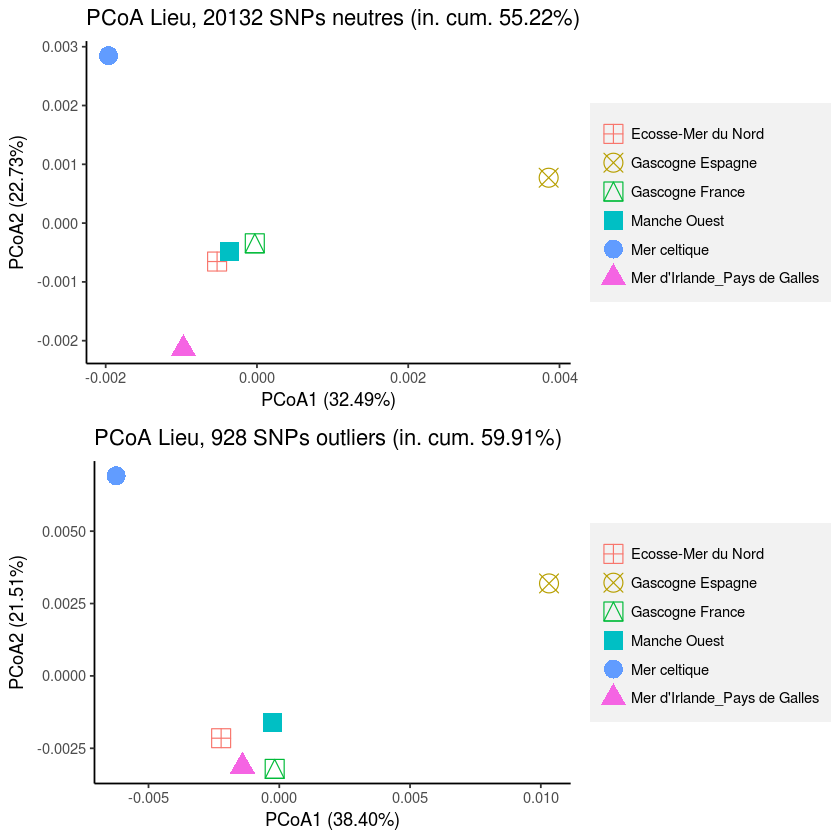

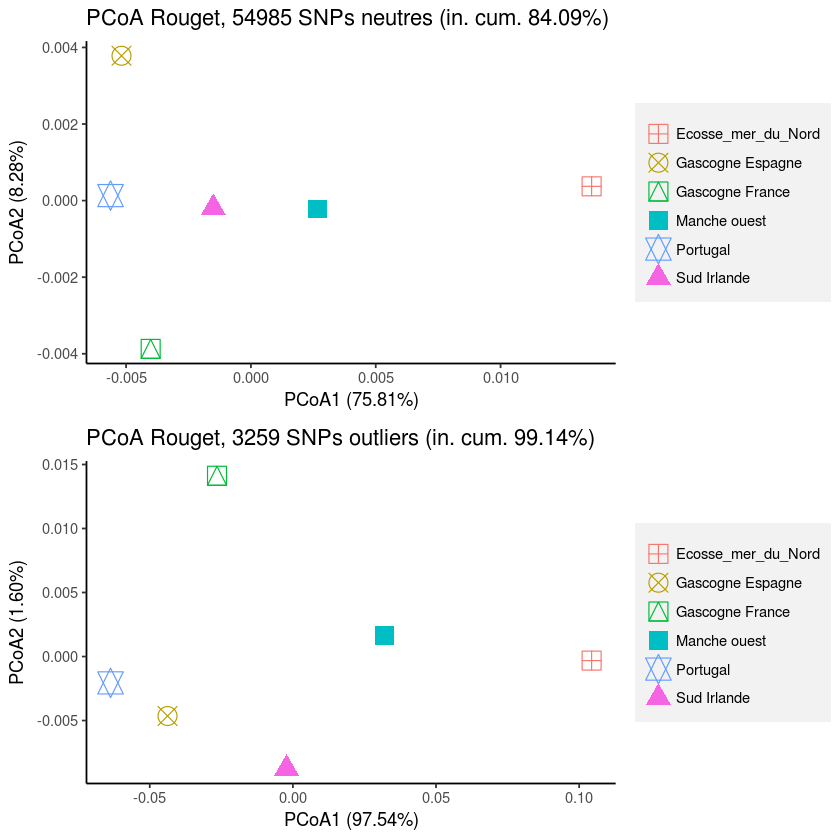

In [4]:
# kernel: R
###############################
# PCOA sur matrice de Nei
###############################
library(ggplot2)
library(vegan)
library(ade4)
library(gridExtra)
library(cowplot)
mytheme <- theme_classic()
mytheme$axis.line.x <- mytheme$axis.line.y <- mytheme$axis.line

# sur Fréquences alléliques
# neutres
pco_PPOL_FA_neutres <- dudi.pco(PPOL_FA_neutres_dist, scannf=FALSE,nf=2)
inertia.dudi(pco_PPOL_FA_neutres)
cp1_2_PPOL_FA_neutres <- as.data.frame(pco_PPOL_FA_neutres$li)
PPOL_pool_names -> cp1_2_PPOL_FA_neutres$pools
PCO1 <- ggplot(cp1_2_PPOL_FA_neutres, aes(x= A1, y= A2)) + geom_point(aes(color=pools, shape=pools), size=5) + 
  mytheme + scale_shape_manual(values=c(12:17)) +
  labs(x="PCoA1 (32.49%)", y="PCoA2 (22.73%)", title="PCoA Lieu, 20132 SNPs neutres (in. cum. 55.22%)") + 
  theme(legend.position="right",legend.title = element_blank(),legend.background=element_rect(fill="grey95"))
pco_MSUR_FA_neutres <- dudi.pco(MSUR_FA_neutres_dist, scannf=FALSE,nf=2)
inertia.dudi(pco_MSUR_FA_neutres)
cp1_2_MSUR_FA_neutres <- as.data.frame(pco_MSUR_FA_neutres$li)
MSUR_pool_names -> cp1_2_MSUR_FA_neutres$pools
PCO2 <- ggplot(cp1_2_MSUR_FA_neutres, aes(x= A1, y= A2)) + geom_point(aes(color=pools, shape=pools), size=5) + 
  mytheme + scale_shape_manual(values=c(12:15,11,17)) +
  labs(x="PCoA1 (75.81%)", y="PCoA2 (8.28%)", title="PCoA Rouget, 54985 SNPs neutres (in. cum. 84.09%)") +
  theme(legend.position="right",legend.title = element_blank(),legend.background=element_rect(fill="grey95"))

# outliers
pco_MSUR_FA_outliers <- dudi.pco(MSUR_FA_outliers_dist, scannf=FALSE,nf=2)
inertia.dudi(pco_MSUR_FA_outliers)
cp1_2_MSUR_FA_outliers <- as.data.frame(pco_MSUR_FA_outliers$li)
MSUR_pool_names -> cp1_2_MSUR_FA_outliers$pools
PCO4 <- ggplot(cp1_2_MSUR_FA_outliers, aes(x= A1, y= A2)) + geom_point(aes(color=pools, shape=pools), size=5) + 
  mytheme + scale_shape_manual(values=c(12:15,11,17)) +
  labs(x="PCoA1 (97.54%)", y="PCoA2 (1.60%)", title="PCoA Rouget, 3259 SNPs outliers (in. cum. 99.14%)") + 
  theme(legend.position="right",legend.title = element_blank(),legend.background=element_rect(fill="grey95"))
pco_PPOL_FA_outliers <- dudi.pco(PPOL_FA_outliers_dist, scannf=FALSE,nf=2)
inertia.dudi(pco_PPOL_FA_outliers)
cp1_2_PPOL_FA_outliers <- as.data.frame(pco_PPOL_FA_outliers$li)
PPOL_pool_names -> cp1_2_PPOL_FA_outliers$pools
PCO3 <- ggplot(cp1_2_PPOL_FA_outliers, aes(x= A1, y= A2)) + geom_point(aes(color=pools, shape=pools), size=5) + 
  mytheme + scale_shape_manual(values=c(12:17)) +
  labs(x="PCoA1 (38.40%)", y="PCoA2 (21.51%)", title="PCoA Lieu, 928 SNPs outliers (in. cum. 59.91%)") + 
  theme(legend.position="right",legend.title = element_blank(),legend.background=element_rect(fill="grey95"))
grid.arrange(PCO1,PCO3)
grid.arrange(PCO2,PCO4)

Dendrogrammes par UPGMA sur neutres et outliers

**PPOL**: le sud de l'aire de répartition se détache nettement (Gascogne Espagne), la mer celtique un peu moins.

**MSUR**: l'Ecosse - Mer du nord se détache nettement, la Manche occidentale un peu moins.

Loading required package: treeio

Attaching package: ‘treeio’

The following objects are masked from ‘package:ape’:

    drop.tip, Nnode, Ntip

ggtree v1.10.4  For help: https://guangchuangyu.github.io/ggtree

If you use ggtree in published research, please cite:
Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution 2017, 8(1):28-36, doi:10.1111/2041-210X.12628

Attaching package: ‘ggtree’

The following object is masked from ‘package:ape’:

    rotate

The following object is masked from ‘package:tidyr’:

    expand

The following object is masked from ‘package:dplyr’:

    collapse



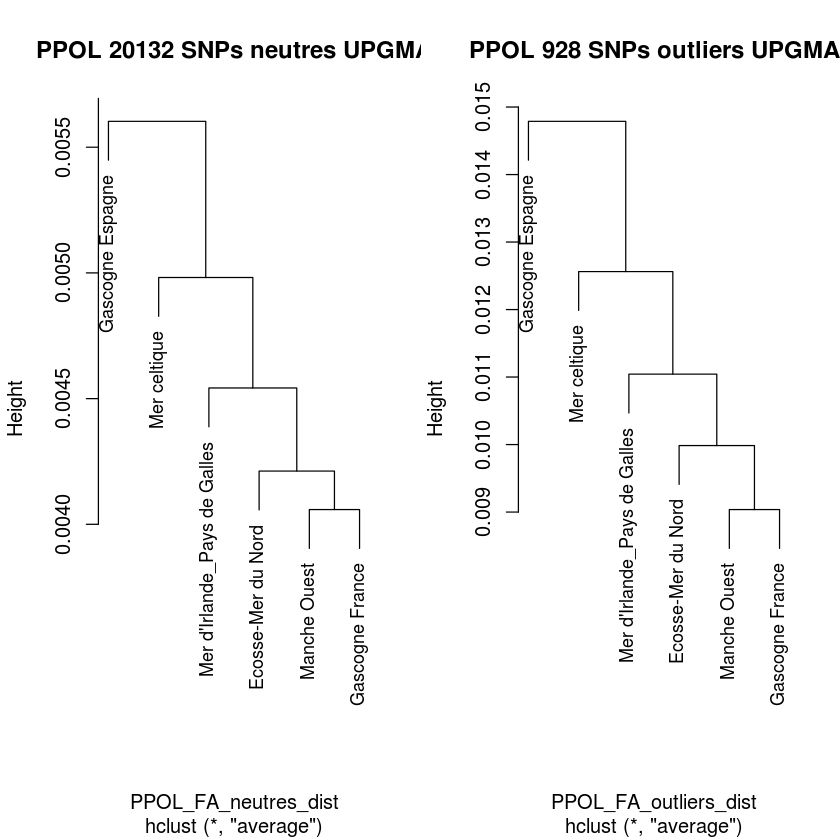

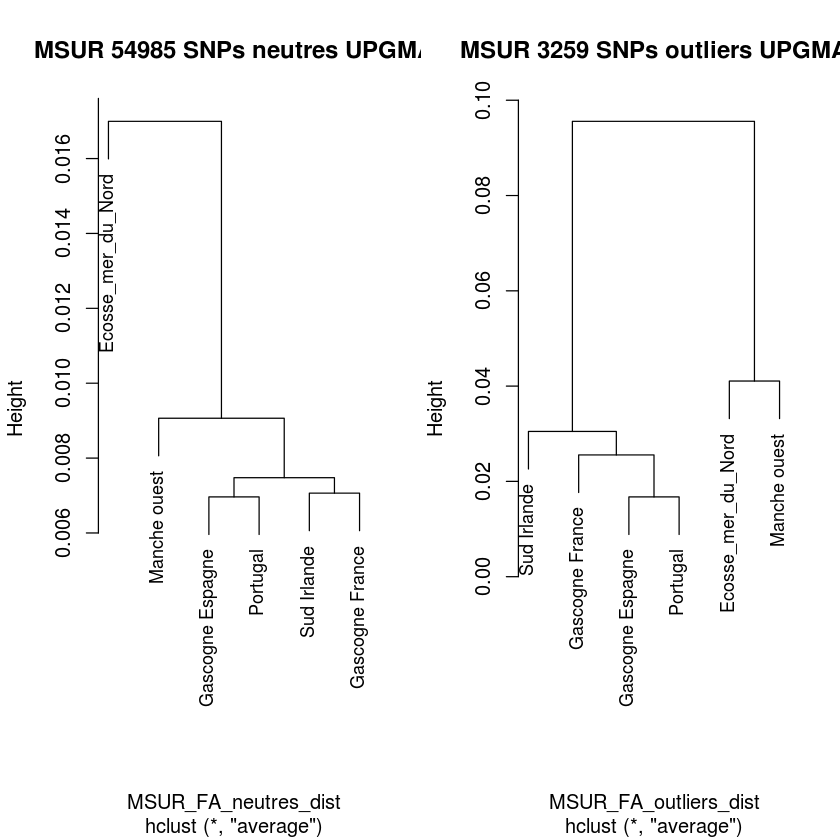

In [5]:
# kernel: R
###############
#### CLUSTERING
###########################
library(ape)
library(ggtree)
# source("https://bioconductor.org/biocLite.R")
# biocLite("ggtree")
# PPOL
h_PPOL_FA_neutres_av <- hclust(PPOL_FA_neutres_dist, method="average")
h_PPOL_FA_outliers_av <- hclust(PPOL_FA_outliers_dist, method="average")
PPOL_pool_names -> h_PPOL_FA_neutres_av$labels -> h_PPOL_FA_outliers_av$labels
par(mfrow=c(1,2))
plot(h_PPOL_FA_neutres_av, label=h_PPOL_FA_neutres_av$labels, main="PPOL 20132 SNPs neutres UPGMA", cex=.9)
plot(h_PPOL_FA_outliers_av, label=h_PPOL_FA_outliers_av$labels, main="PPOL 928 SNPs outliers UPGMA", cex=.9)

# MSUR
h_MSUR_FA_neutres_av <- hclust(MSUR_FA_neutres_dist, method="average")
h_MSUR_FA_outliers_av <- hclust(MSUR_FA_outliers_dist, method="average")
MSUR_pool_names -> h_MSUR_FA_neutres_av$labels -> h_MSUR_FA_outliers_av$labels
par(mfrow=c(1,2))
plot(h_MSUR_FA_neutres_av, label=h_MSUR_FA_neutres_av$labels, main="MSUR 54985 SNPs neutres UPGMA", cex=.9)
plot(h_MSUR_FA_outliers_av, label=h_MSUR_FA_outliers_av$labels, main="MSUR 3259 SNPs outliers UPGMA", cex=.9)

# **Test des regroupements de pools dans les clusters**

K-means with vegan::cascadeKM()

In [20]:
#############
# cascadeKM
#############
# mêmes résultats que les clusters

MSUR_pool_names -> rownames(MSUR_FA_neutres_df1t)
cascadeKM(MSUR_FA_neutres_df1t,2,5,criterion="ssi")
cascadeKM(MSUR_FA_neutres_df1t,2,5,criterion="calinski")

PPOL_pool_names -> rownames(PPOL_FA_neutres_df1t)
cascadeKM(PPOL_FA_neutres_df1t,2,5,criterion="ssi")
cascadeKM(PPOL_FA_neutres_df1t,2,5,criterion="calinski")

##############

$partition
                   2 groups 3 groups 4 groups 5 groups
Ecosse_mer_du_Nord        1        2        3        2
Sud Irlande               2        1        4        1
Manche ouest              2        3        1        5
Gascogne France           2        1        4        4
Gascogne Espagne          2        1        2        3
Portugal                  2        1        2        3

$results
        2 groups     3 groups     4 groups    5 groups
SSE 574.67438896 391.31431832 249.46442521 123.5424439
ssi   0.02616662   0.03252284   0.06174775   0.0593605

$criterion
[1] "ssi"

$size
        2 groups 3 groups 4 groups 5 groups
Group 1        1        4        1        1
Group 2        5        1        2        1
Group 3       NA        1        1        2
Group 4       NA       NA        2        1
Group 5       NA       NA       NA        1

attr(,"class")
[1] "cascadeKM"

$partition
                   2 groups 3 groups 4 groups 5 groups
Ecosse_mer_du_Nord        2        3        1        2
Sud Irlande               1        1        2        5
Manche ouest              1        2        3        4
Gascogne France           1        1        2        3
Gascogne Espagne          1        1        4        1
Portugal                  1        1        4        1

$results
           2 groups   3 groups   4 groups   5 groups
SSE      574.674389 391.314318 249.464425 123.542444
calinski   2.898313   2.299009   1.981863   1.755527

$criterion
[1] "calinski"

$size
        2 groups 3 groups 4 groups 5 groups
Group 1        5        4        1        2
Group 2        1        1        2        1
Group 3       NA        1        1        1
Group 4       NA       NA        2        1
Group 5       NA       NA       NA        1

attr(,"class")
[1] "cascadeKM"

$partition
                             2 groups 3 groups 4 groups 5 groups
Ecosse-Mer du Nord                  1        2        2        5
Mer celtique                        1        3        1        3
Mer d'Irlande_Pays de Galles        1        2        3        1
Manche Ouest                        1        2        2        4
Gascogne France                     1        2        2        4
Gascogne Espagne                    2        1        4        2

$results
        2 groups   3 groups    4 groups   5 groups
SSE 115.23654863 81.7738100 52.14409835 25.4815498
ssi   0.01280982  0.0172018  0.02355661  0.0364713

$criterion
[1] "ssi"

$size
        2 groups 3 groups 4 groups 5 groups
Group 1        5        1        1        1
Group 2        1        4        3        1
Group 3       NA        1        1        1
Group 4       NA       NA        1        2
Group 5       NA       NA       NA        1

attr(,"class")
[1] "cascadeKM"

$partition
                             2 groups 3 groups 4 groups 5 groups
Ecosse-Mer du Nord                  1        1        2        3
Mer celtique                        1        2        1        1
Mer d'Irlande_Pays de Galles        1        1        4        4
Manche Ouest                        1        1        2        2
Gascogne France                     1        1        2        2
Gascogne Espagne                    2        3        3        5

$results
           2 groups  3 groups 4 groups  5 groups
SSE      115.236549 81.773810 52.14410 25.481550
calinski   1.369183  1.337367  1.31095  1.267584

$criterion
[1] "calinski"

$size
        2 groups 3 groups 4 groups 5 groups
Group 1        5        4        1        1
Group 2        1        1        3        2
Group 3       NA        1        1        1
Group 4       NA       NA        1        1
Group 5       NA       NA       NA        1

attr(,"class")
[1] "cascadeKM"

# Calcul des Fst globaux

Le Fst global de chaque espèce est très faible.
Impossible de calculer des Fst par pool, ne disposant pas de variance ni de moyenne intra-pool.

In [7]:
########################
# Hardy-Weinberg F-stats
########################
library(dplyr)
library(stringr)
library(matrixStats)

# PPOL
PPOL_FAs <- as.matrix(subset(PPOL_FA,select=c(G1_1p, G2_1p, G3_1p, G4_1p, G5_1p, G6_1p)))
rowVars(PPOL_FAs) -> variances
rowMeans(PPOL_FAs) -> means
variances*(1-means)-> Fst_locus -> PPOL_FA$Fst_locus
PPOL_FA %>% summarise(Fst_avg_PPOL_all=mean(Fst_locus)) # 0.000845

PPOL_FAs_neutres <- as.matrix(subset(PPOL_FA_neutres,select=c(G1_1p, G2_1p, G3_1p, G4_1p, G5_1p, G6_1p)))
rowVars(PPOL_FAs_neutres) -> variances
rowMeans(PPOL_FAs_neutres) -> means
variances*(1-means)-> Fst_locus -> PPOL_FA_neutres$Fst_locus
PPOL_FA_neutres %>% summarise(Fst_avg_PPOL_neutres=mean(Fst_locus)) # 0.000777

# MSUR
MSUR_FAs <- as.matrix(subset(MSUR_FA,select=c(G1_1p, G2_1p, G3_1p, G4_1p, G5_1p, G6_1p)))
rowVars(MSUR_FAs) -> variances
rowMeans(MSUR_FAs) -> means
variances*(1-means)-> Fst_locus -> MSUR_FA$Fst_locus
MSUR_FA %>% summarise(Fst_avg_MSUR_all=mean(Fst_locus)) # 0.00223

MSUR_FAs_neutres <- as.matrix(subset(MSUR_FA_neutres,select=c(G1_1p, G2_1p, G3_1p, G4_1p, G5_1p, G6_1p)))
rowVars(MSUR_FAs_neutres) -> variances
rowMeans(MSUR_FAs_neutres) -> means
variances*(1-means)-> Fst_locus -> MSUR_FA_neutres$Fst_locus
MSUR_FA_neutres %>% summarise(Fst_avg_MSUR_neutres=mean(Fst_locus)) # 0.00175

Fst_avg_PPOL_all
0.0008454265


Fst_avg_PPOL_neutres
0.0007771414


Fst_avg_MSUR_all
0.002225212


Fst_avg_MSUR_neutres
0.001754177
